# Explore Entur Vehicle Monitoring

In [36]:
import requests
import pandas as pd

import geopandas
from lxml import etree

In [37]:
base_url = "https://api.entur.io/realtime/v1/rest/vm"
resp = requests.get(f"{base_url}?maxSize=100000")
assert resp.ok
prstree = etree.fromstring(resp.content) 
nsmap = {
    'siri': 'http://www.siri.org.uk/siri',
    'ns2': "http://www.ifopt.org.uk/acsb",
    "ns3": "http://www.ifopt.org.uk/ifopt",
    "ns4": "http://datex2.eu/schema/2_0RC1/2_0",
}

In [38]:
all_items = []
for vehicle_activity in prstree.iter(etree.QName(nsmap["siri"], "VehicleActivity")):
    vehicle_activity_dict = {etree.QName(x).localname : x.text for x in vehicle_activity if x.text is not None}
    monitored_journey = vehicle_activity.find(etree.QName(nsmap["siri"], "MonitoredVehicleJourney"))
    monitored_journey_dict = {etree.QName(x).localname : x.text for x in monitored_journey if x.text is not None}
    vehicle_location = monitored_journey.find(etree.QName(nsmap["siri"], "VehicleLocation"))
    if vehicle_location is not None:
        vehicle_location_dict = {etree.QName(x).localname : x.text for x in vehicle_location if x.text is not None}
    else:
        vehicle_location = {}

    all_items.append(vehicle_activity_dict | monitored_journey_dict | vehicle_location_dict)

df_raw = pd.DataFrame(all_items).convert_dtypes(dtype_backend="pyarrow")
df_raw.T

,0,1,2,3,4,5,6,7,8,9,...,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935
RecordedAtTime,2024-03-24T19:20:44+01:00,2024-03-24T20:42:19+01:00,2024-03-24T23:00:21+01:00,2024-03-24T21:09:39+01:00,2024-03-24T23:00:07.926+01:00,2024-03-24T19:21:28+01:00,2024-03-24T23:00:04+01:00,2024-03-24T18:46:00+01:00,2024-03-24T21:53:53+01:00,2024-03-22T17:01:38+01:00,...,2024-03-24T21:51:14+01:00,2024-03-21T16:15:17+01:00,2024-03-22T15:10:22+01:00,2024-03-24T18:23:10+01:00,2024-03-24T23:00:22+01:00,2024-03-22T17:08:00+01:00,2024-03-24T20:10:18+01:00,2024-03-24T23:00:12.716+01:00,2024-03-24T19:25:49+01:00,2024-03-24T19:21:05+01:00
ValidUntilTime,2024-03-25T01:20:44+01:00,2024-03-25T02:42:19+01:00,2024-03-25T05:00:21+01:00,2024-03-25T03:09:39+01:00,2024-03-24T23:10:07.926+01:00,2024-03-25T01:21:28+01:00,2024-03-25T05:00:04+01:00,2024-03-25T00:46:00+01:00,2024-03-25T03:53:53+01:00,9999-12-31T23:59:59+01:00,...,2024-03-25T03:51:14+01:00,9999-12-31T23:59:59+01:00,9999-12-31T23:59:59+01:00,9999-12-31T23:59:59+01:00,2024-03-25T05:00:22+01:00,9999-12-31T23:59:59+01:00,2024-03-25T02:10:18+01:00,2024-03-25T11:00:12.716+01:00,2024-03-25T01:25:49+01:00,2024-03-25T01:21:05+01:00
LineRef,SKY:Line:3,TRO:Line:1_362,SKY:Line:5,SKY:Line:3,VYB:Line:22,SKY:Line:5,SKY:Line:5,SKY:Line:552,SKY:Line:552,NOR:Line:8647,...,SKY:Line:20,NOR:Line:3754,NOR:Line:8472,NOR:Line:3754,SKY:Line:495,NOR:Line:8472,SKY:Line:620,FIN:Line:2350,SKY:Line:326,TRO:Line:1_380
VehicleMode,bus,bus,bus,bus,<NA>,bus,bus,bus,bus,<NA>,...,bus,<NA>,<NA>,<NA>,bus,<NA>,bus,ferry,bus,bus
OperatorRef,SKY:Operator:44,TRO:Operator:961,SKY:Operator:44,SKY:Operator:44,<NA>,SKY:Operator:44,SKY:Operator:44,SKY:Operator:38,SKY:Operator:38,<NA>,...,SKY:Operator:45,<NA>,<NA>,<NA>,SKY:Operator:7,<NA>,SKY:Operator:38,<NA>,SKY:Operator:12,TRO:Operator:961
VehicleFeatureRef,SignageModeAutomatic,SignageModeAutomatic,SignageModeAutomatic,SignageModeAutomatic,<NA>,SignageModeAutomatic,SignageModeAutomatic,SignageModeAutomatic,SignageModeAutomatic,<NA>,...,SignageModeAutomatic,<NA>,<NA>,<NA>,SignageModeAutomatic,<NA>,SignageModeAutomatic,<NA>,SignageModeAutomatic,SignageModeAutomatic
OriginRef,NSR:Quay:12011356,NSR:Quay:93319,NSR:Quay:12016437,NSR:Quay:12011356,<NA>,NSR:Quay:12016436,NSR:Quay:12012289,NSR:Quay:12197963,NSR:Quay:12197963,<NA>,...,NSR:Quay:12012302,<NA>,<NA>,<NA>,NSR:Quay:12473622,<NA>,NSR:Quay:12215002,NSR:Quay:98145,NSR:Quay:12644914,NSR:Quay:102333
OriginName,Støbotn snuplass,Straumsbotn,Sletten,Støbotn snuplass,<NA>,Sletten snuplass,Fyllingsdalen terminal E,Svortland terminal D,Svortland terminal D,<NA>,...,Storavatnet terminal A,<NA>,<NA>,<NA>,Ramsøy snuplass,<NA>,Leirvik terminal B,Måsøy,Mastrevik torg,Gibostad
DestinationRef,NSR:Quay:53799,NSR:Quay:90730,NSR:Quay:106946,GAR4.402,<NA>,GAR4.402,NSR:Quay:105587,GAR3.503,GAR3.503,<NA>,...,NSR:Quay:55005,<NA>,<NA>,<NA>,NSR:Quay:53031,<NA>,NSR:Quay:103637,NSR:Quay:98140,NSR:Quay:102566,NSR:Quay:108838
DestinationName,skyss.no,Skaland skole,Fyllingsdalen terminal,skyss.no,<NA>,skyss.no,Sletten,skyss.no,skyss.no,<NA>,...,skyss.no,<NA>,<NA>,<NA>,Bergen busstasjon,<NA>,Svortland,Havøysund,Knarvik terminal,Finnsnes kai


In [39]:
df = (df_raw
 .assign(
    # RecordedAtTime=pd.to_datetime(df_raw.RecordedAtTime, format="ISO8601"),
    # ValidUntilTime=pd.to_datetime(df_raw.ValidUntilTime, format="ISO8601", errors="coerce"),
    # Bearing=df_raw.Bearing.astype("float32[pyarrow]"),
   #  Delay=pd.to_timedelta(df_raw.Delay),
 )
)
df.dtypes

RecordedAtTime                 string[pyarrow]
ValidUntilTime                 string[pyarrow]
LineRef                        string[pyarrow]
VehicleMode                    string[pyarrow]
OperatorRef                    string[pyarrow]
VehicleFeatureRef              string[pyarrow]
OriginRef                      string[pyarrow]
OriginName                     string[pyarrow]
DestinationRef                 string[pyarrow]
DestinationName                string[pyarrow]
Monitored                      string[pyarrow]
InCongestion                   string[pyarrow]
DataSource                     string[pyarrow]
Bearing                        string[pyarrow]
Delay                          string[pyarrow]
VehicleStatus                  string[pyarrow]
VehicleRef                     string[pyarrow]
IsCompleteStopSequence         string[pyarrow]
Longitude                      string[pyarrow]
Latitude                       string[pyarrow]
Occupancy                      string[pyarrow]
PublishedLine

In [40]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)
gdf.head()

,RecordedAtTime,ValidUntilTime,LineRef,VehicleMode,OperatorRef,VehicleFeatureRef,OriginRef,OriginName,DestinationRef,DestinationName,...,Velocity,VehicleMonitoringRef,VehicleJourneyRef,OriginAimedDepartureTime,BlockRef,JourneyPatternRef,JourneyPatternName,DirectionName,LocationRecordedAtTime,geometry
0,2024-03-24T19:20:44+01:00,2024-03-25T01:20:44+01:00,SKY:Line:3,bus,SKY:Operator:44,SignageModeAutomatic,NSR:Quay:12011356,Støbotn snuplass,NSR:Quay:53799,skyss.no,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.37098 60.46235)
1,2024-03-24T20:42:19+01:00,2024-03-25T02:42:19+01:00,TRO:Line:1_362,bus,TRO:Operator:961,SignageModeAutomatic,NSR:Quay:93319,Straumsbotn,NSR:Quay:90730,Skaland skole,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (17.28600 69.44627)
2,2024-03-24T23:00:21+01:00,2024-03-25T05:00:21+01:00,SKY:Line:5,bus,SKY:Operator:44,SignageModeAutomatic,NSR:Quay:12016437,Sletten,NSR:Quay:106946,Fyllingsdalen terminal,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.32759 60.39321)
3,2024-03-24T21:09:39+01:00,2024-03-25T03:09:39+01:00,SKY:Line:3,bus,SKY:Operator:44,SignageModeAutomatic,NSR:Quay:12011356,Støbotn snuplass,GAR4.402,skyss.no,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.38431 60.48279)
4,2024-03-24T23:00:07.926+01:00,2024-03-24T23:10:07.926+01:00,VYB:Line:22,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (11.97186 57.71038)


In [41]:
gdf.explore(cmap="Blues")  

<Axes: xlabel='VehicleMode'>

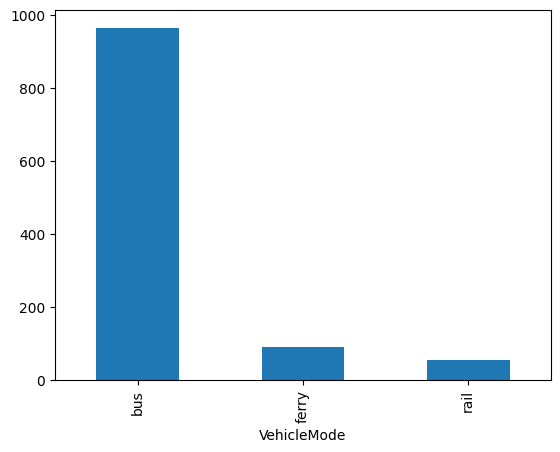

In [42]:
df["VehicleMode"].value_counts().plot.bar()

<Axes: xlabel='DataSource'>

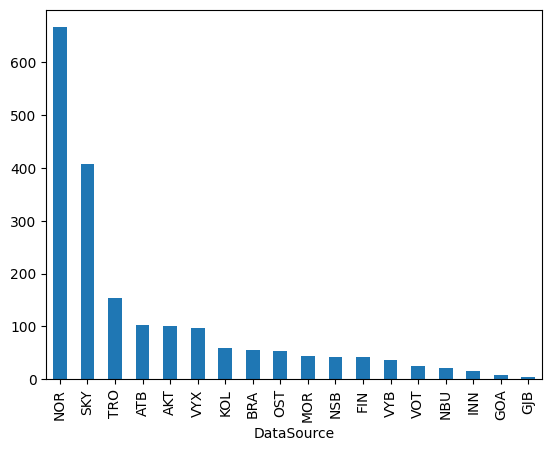

In [43]:
df["DataSource"].value_counts().plot.bar()